# Medical AI 勉強会 Part1 CNNの解釈
> 畳み込みニューラルネットワークの推論過程の解釈法をCheXNetを例に学ぶ。

- toc: true 
- badges: false
- comments: true
- categories: [Medical AI]
- image: images/chest-cam.png

# CheXNetとは

## 概要
[CheXNet article](https://arxiv.org/pdf/1711.05225.pdf)

主旨：2017年に公表された、NIHの公開している14疾患のラベル付き胸部X線画像に対して肺炎検出タスクをCNNに学習させ、放射線技師を上回るF1スコアを出せたという論文。肺炎検出という2値分類タスクから、14疾患の検出という多クラス分類タスクへと拡張し、過去のモデルを上回るAUROCスコアもだせたとも言っている。

**画像のどこが推論に対して影響力が大きいか表したヒートマップ（CAMs）も導入している。**

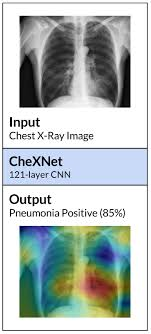

## Dataset

1. 30805人の患者の112120枚の前面胸部X線画像（1024*1024 png）
2. 各画像には14種類の疾患ラベルが複数可で紐づいている。
    * ラベルは診断分をNLPによって生成したもので、精度は90+％程
    * NLPによる抽出法はCoursera AI for treatmentで紹介されている。
3. 1000枚弱の画像に対して、病変部のBounding boxの座標が示されている。

NIHの元データセット：https://nihcc.app.box.com/v/ChestXray-NIHCC \
Kaggleバージョン：https://www.kaggle.com/nih-chest-xrays/data

## Model architecture 

ベースモデルは**DenseNet**。最後の特徴量マップにGlobal averaging pooling、その次に全結合、そのアウトプットにSigmoid活性化関数を適応してラベル予測確率を出す小構造になっている。Kerasだと下のようになる。
```
from keras.applications.densenet import DenseNet121
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

base_model = DenseNet121(include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(len(labels), activation="sigmoid")(x)
model = Model(inputs=base_model.input, outputs=predictions)
```
肺炎検出の場合はアウトプットがSingle outputで済むので`len(labels)`は１になる。14疾患の多クラス分類の時は14である。

今回、**最後の特徴量マップ**と**Global averaging pooling**がヒートマップ作成の重要なキーとなる。

### DenseNet - Densely Connected Convolutional Networks


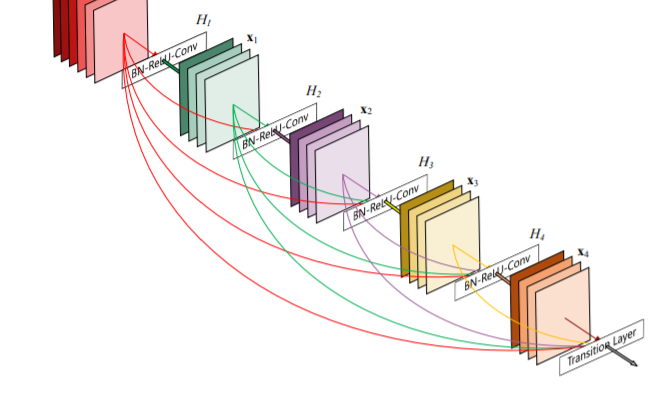

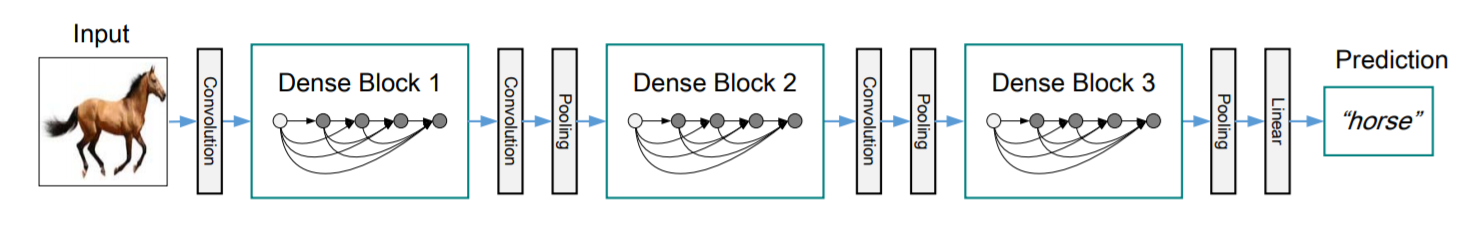

#### Dense Block
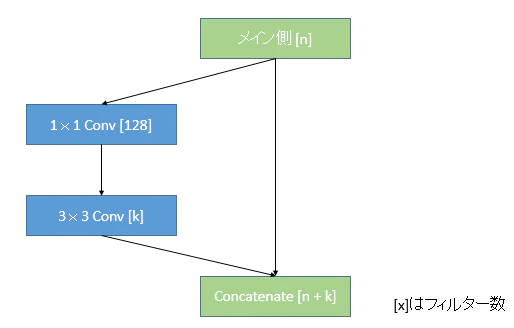

https://arxiv.org/pdf/1608.06993.pdf

https://qiita.com/koshian2/items/01bd9f08444799625607

特徴量マップ層をどんどん積み重ねていくこと（Concatenate）が肝。ResNetみたいに飛び飛びの接続が見られる。

CheXNetでは、最後に得られた特徴量マップの層ごとにGlobal averaging pooling (GAP)した値、つまり層の数 k 個の値を全結合にインプットして予測値へと変換する。

* 「情報をチャンネル単位で積み重ねているのだから、Flattenでチャンネルの内の個々の値を使うより、GAPでチャンネル単位での平均を取ったほうがより自然」

## Model training

* ImageNetの重みで初期化
* Adam with standard parameters (β1 = 0.9 and β2 = 0.999) 
* バッチサイズ：16
* 学習率0.001からバリデーションロスの改善が１エポック後に見られなかったら10分の１ずつ減らし、一番ロスの低いモデルを選ぶ

### Loss function
2値分類の時は
$$L(X, y) = −w_+ ylog p(Y = 1|X)
−w_−  (1 − y) log p(Y = 0|X)$$
通常のクロスエントロピーにそれぞれのクラスのポジティブの割合とネガティブの割合で重み付けした値を使っている。14疾患への拡張は同様にマルチクロスエントロピーを重み付けした値を使っている（と思ったが論文では重み付けはしてなかった）。

# Heatmap

## CAM - Class Activation Mapping 

画像の部位ごとの推論における重要性を表すのが目標。出力層の最後の特徴量マップに対する重みを投影しなおすことで可能になるらしい。Class Activation Mappingと筆者等は言っている。

[CAM article](http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf)をCheXNetは引用していた。

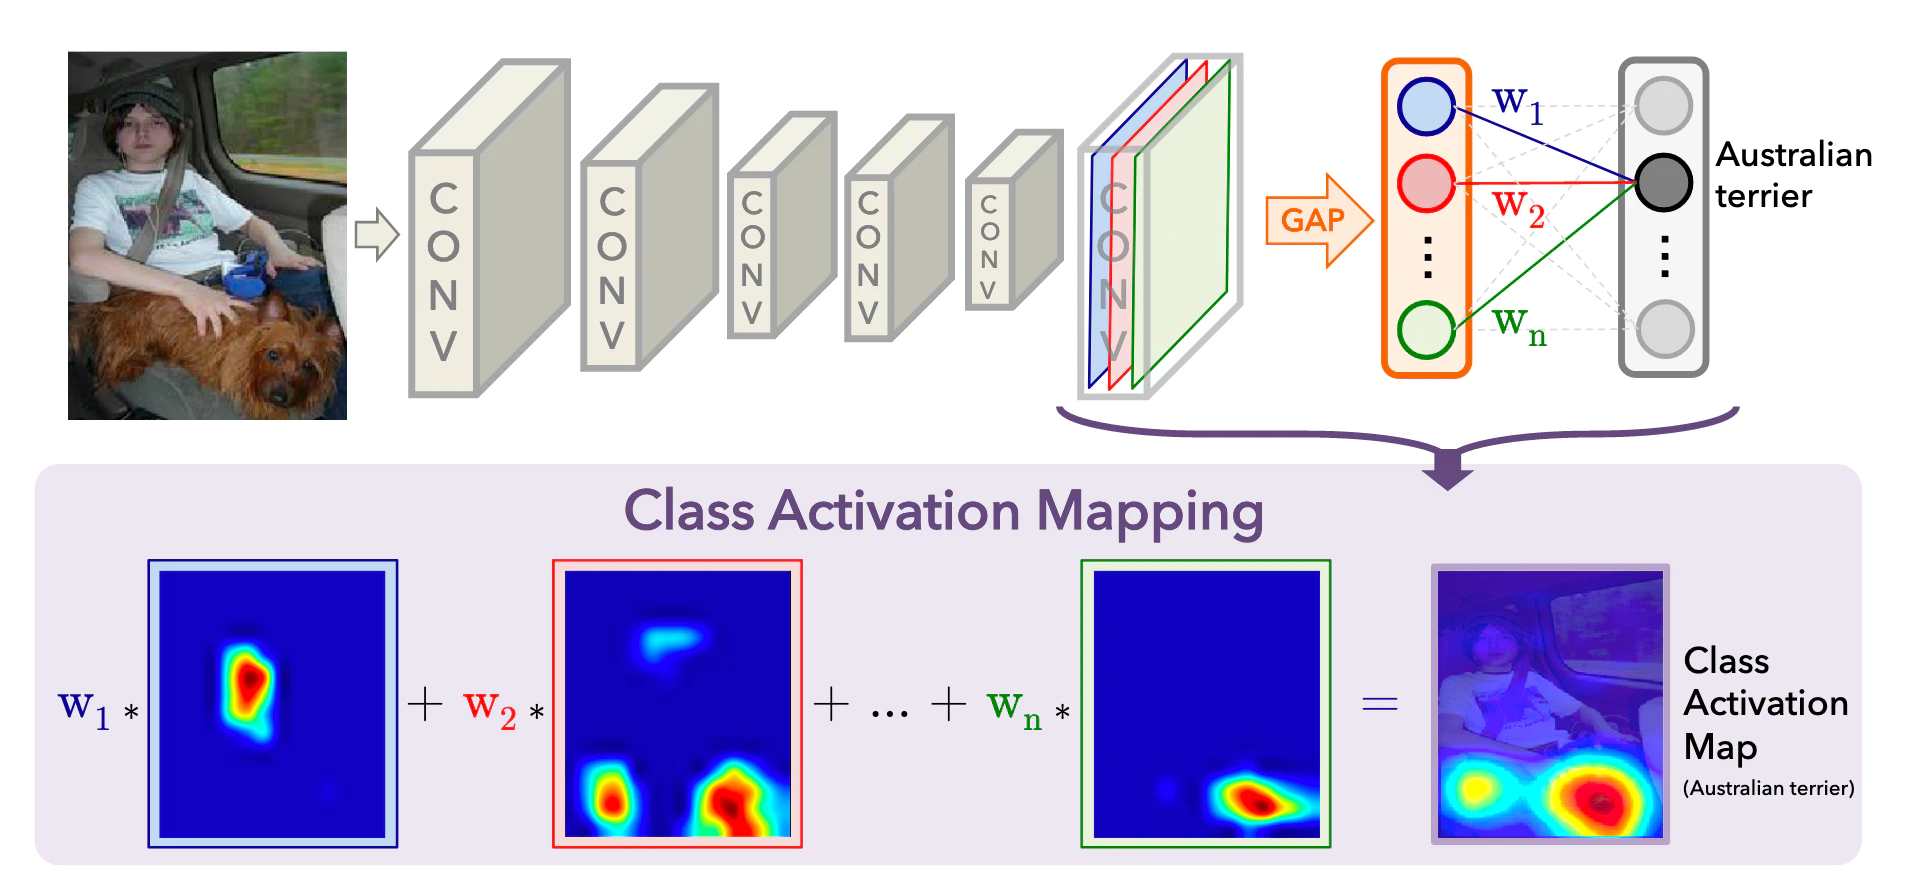

CAMを使うには、上図のように、最後の特徴量マップ（青、赤、緑）にGAPを適応することで、各層の特徴量マップの平均値を出力層に入力している構造が前提である。

元論文のアルゴリズムは以下の通りである。

$f_k(x,y)$を最後の特徴量マップの$k$層目、$(x,y)$の特徴量座標の活性化値とする。GAP適応後の値を$F_k$と表すと、
$$F_k=\frac{1}{Z}\Sigma_{x,y}f_k(x,y)$$
ただし、$Z$は$k$層目の特徴量マップの要素数である。クラス$c$における、全結合層での$F_k$に対する重み、$w_k^c$で重み付け加算された値が出力層のSoftmax活性化関数手前の出力$S_c$なので、
$$S_c=\Sigma_k w^c_kF_k=\frac{1}{Z}\Sigma_{x,y}\Sigma_kw^c_kf_k(x,y)$$
これに対し、今回得たいクラス$c$に関してのCAMを$M_c$とおいて、CAMの各要素を
$$M_c(x,y)=\Sigma_kw^c_kf_k(x,y)$$
と定義する。結果、
$$S_c=\frac{1}{Z}\Sigma_{x,y}M_c(x,y)$$
ともかける。なので、$M_c(x,y)$は空間グリッド$(x,y)$での活性がクラス$c$の推論においてどれほど貢献しているか、つまりどれほど重要か直接意味していると考えることができる。

特徴量マップはインプットされた画像を*downsampling*して生じたデータである。$M_c$は１層の特徴量マップと同じサイズなので、ヒートマップとして表示するには*upsampling*して元の画像サイズにもどしてあげる必要がある。

## grad CAM
CAMの進化版にgrad CAMがある。Courseraの[Coursera AI for medicine](https://www.coursera.org/specializations/ai-for-medicine)ではこれを使用している。こちらでは
$$M_c(x,y)=ReLU(\Sigma_k\alpha^c_kf_k(x,y))$$
と定義される。$\alpha^c_k$は*Average influence*ともいわれたりして、$k$層目の特徴量マップがどれほどアウトプットに影響を与えるかを表す。
$$\alpha^c_k=\frac{1}{Z}\Sigma_{x,y}\frac{\delta y^c}{\delta f^k_{x,y}}$$
と定義され、クラス$c$予測値$y^c$の特徴量マップの要素ごとの偏微分の平均と同値である。先ほどのCAMでは全結合層での重み$w^c_k$を直接使っていたが、今回はより実際のアウトプットにどれだけ寄与しているかというより直観的な意味合いを$\alpha^c_k$が持っていることがわかる。

ReLUに関して、特徴量マップのアウトプットに対する寄与としてポジティブの成分しか興味がないので、ReLUを適応して、$M_c(x,y)$の負値を0にしている。

$M^c$が求まったら*upsampling*して元の画像サイズに戻してあげる。

## Other methods
その他、二階微分・三階微分を用いる [grad CAM ++](https://arxiv.org/abs/1710.11063) や 偏微分による勾配計算を用いない [Score CAM](https://arxiv.org/pdf/1910.01279.pdf)などの手法が開発されてきている。手法の発展と共に可視化の精度はよくなってきている一方、ランニングコストが高くなってきている。

# CheXNet + grad CAM
Coursera にのってる学習済みモデルを借りパくして、次のサイトに実装してみた。実際の予測結果と推論でどこをフォーカスしていたかを表すヒートマップが見れる。

https://chexnet-demo-app.herokuapp.com/